In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

In [4]:
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

100.0%
100.0%
100.0%
100.0%


In [5]:
images_train, labels_train = next(iter(train_loader))

In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

In [7]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

std_Xav1 = (6 / (28*28 + 500)) ** 0.5
std_Xav2 = (6 / (500 + 10)) ** 0.5
init_layer(layer_1, -std_Xav1, std_Xav1)
init_layer(layer_2, std_Xav2, std_Xav2)

In [15]:
network = nn.Sequential(
    layer_1,
    nn.Tanh(),
    layer_2
)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 1.0042657852172852
forward 0.7838308811187744
backward 0.03333333507180214
backward 0.014952319674193859


При инициализации весов методом **He** в семинаре получились следующие значения:
forward 0.9945185780525208
forward 0.12716735899448395
backward 0.019999997690320015
backward 0.038504574447870255
В итоге Xavier справился лучше с форвардом чем He, но backward изменения практически неощутимы

In [25]:
class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x):
        mask = torch.empty(X.shape).uniform_(0, 1).type(torch.FloatTensor)
        if self.training:
            mask = torch.where(mask > self.p, 1, 0)
        else:
            mask = torch.where(mask > self.p, 1, 1 - self.p)

        return x * mask

In [26]:
class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p
    
    def forward(self, x):
        if self.training:
            mask = torch.empty_like(self.linear.weight).bernoulli_(1 - self.p).type(torch.FloatTensor)
            mask = mask / (1 - self.p)
        else:
            mask = torch.ones_like(self.linear.weight) * (1 - self.p)
        mask = mask.requires_grad_(False)
        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

In [27]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

In [31]:
layers = [
    nn.Linear(196, 150),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(150, 50),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(50, 10)
]

In [32]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

In [33]:
for epoch in range(10):
    network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())

    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.314474
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.052246
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.499934
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.500542
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.484154
Test Epoch: 0	Loss: 0.198261
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.302967
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.395147
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.243073
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.322839
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.229096
Test Epoch: 1	Loss: 0.138520
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.287380
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.220397
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.321338
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.426671
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.246256
Test Epoch: 2	Loss: 0.108665
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.213053
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.172027
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.294702
Train Epoch: 3 [38400/60000 (64%)

In [35]:
DropOut_los = losses

In [36]:
layers = [
    DropConnect(196, 150),
    nn.ReLU(),
    DropConnect(150, 50),
    nn.ReLU(),
    nn.Linear(50, 10)
]

network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

In [38]:
for epoch in range(10):
    network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())

    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.316138
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.019516
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.462464
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.561608
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.440582
Test Epoch: 0	Loss: 0.842350
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.270664
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.328609
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.200235
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.258949
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.205613
Test Epoch: 1	Loss: 0.748747
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.293555
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.319984
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.189328
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.245897
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.240909
Test Epoch: 2	Loss: 0.646753
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.260530
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.132448
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.189943
Train Epoch: 3 [38400/60000 (64%)

In [39]:
DropCon_los = losses

In [48]:
print(DropCon_los)

[0.5013185143470764, 0.5537914633750916, 0.4833216071128845, 0.46736419200897217, 0.5037951469421387, 0.505046010017395, 0.4986209273338318, 0.4851219952106476, 0.48526498675346375, 0.47182056307792664, 0.4701075553894043, 0.45345452427864075, 0.44199058413505554, 0.4839569926261902, 0.4786187410354614, 0.48620590567588806, 0.4882945716381073, 0.4545374810695648, 0.5085354447364807, 0.467609167098999, 0.4784533381462097, 0.5049139261245728, 0.4398655593395233, 0.48418518900871277, 0.49781960248947144, 0.5366194248199463, 0.4673007130622864, 0.443209171295166, 0.5127975344657898, 0.48468929529190063, 0.4938724935054779, 0.4987475574016571, 0.4555152952671051, 0.499927818775177, 0.49714604020118713, 0.44498202204704285, 0.5465871691703796, 0.46299728751182556, 0.5633307099342346, 0.484755277633667, 0.48842155933380127, 0.5300850868225098, 0.5124939680099487, 0.4704361855983734, 0.47040417790412903, 0.45382988452911377, 0.4812477231025696, 0.4815031588077545, 0.49755769968032837, 0.487227

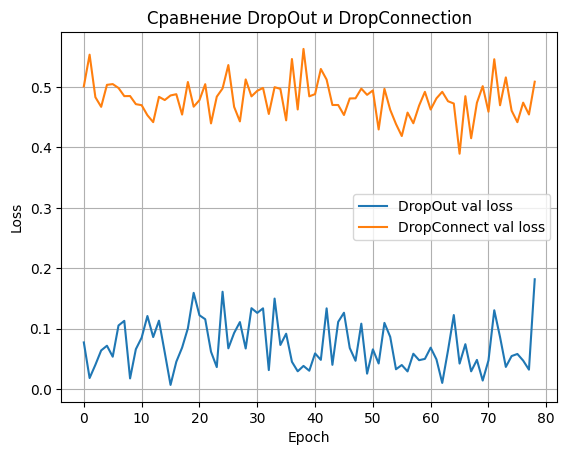

In [53]:
plt.plot(DropOut_los, label='DropOut val loss')
plt.plot( DropCon_los, label='DropConnect val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Сравнение DropOut и DropConnection')
plt.legend()
plt.grid()